In [1]:
# Skript zur Auswertung der Langzeitmessung, Felix Soest & Sebastian Thiede
# Import der benötigten Packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:

# Kanalbreite
width = 41.7e-9

# Datenimport
data = pd.read_csv('data.txt', sep='\t')

# Intervallstartzeit
data['start'] = [ i * width for i in range(256)]
# Intervallmittelzeit
data['mid'] = [ (i + 0.5) * width for i in range(256) ]

# Kanäle 24 - 150 auswählen
cut = data[24:150]


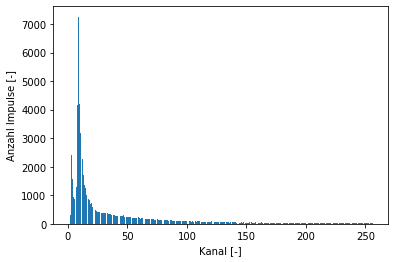

In [4]:
# Histogrammplot Komplett
plt.bar(data['Kanal'], data['Count'])
plt.xlabel('Kanal [-]')
plt.ylabel('Anzahl Impulse [-]')
plt.savefig('images/totaldata.png', dpi=300)

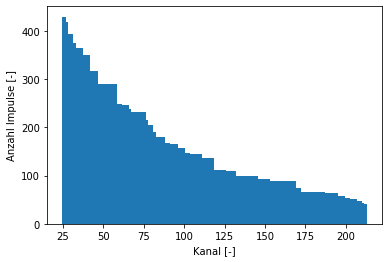

In [5]:
# Histogrammplot Kanäle 24-150
plt.bar(cut['Kanal'], cut['Count'])
plt.xlabel('Kanal [-]')
plt.ylabel('Anzahl Impulse [-]')
plt.savefig('images/cutdata.png', dpi=300)


Aus der exponentiellen Methode ergibt sich τ = 2.1670535077349124e-06 ± 2.166774716086988e-08
Zum Vergleich der Wert ohne Normierung: τ = 2.6717029992169143e-06 ± 2.166774716086988e-08


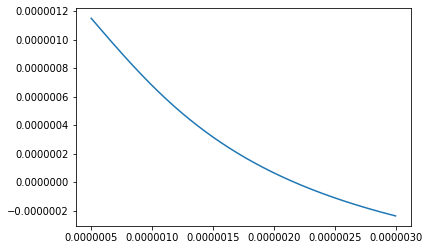

In [6]:
# Exponentielles Zerfallsgesetz

cut_exp = data[24:150]
N_exp = cut_exp['Count'].sum()
T_0 = cut_exp.at[24, 'mid']
T_end = cut_exp.at[149, 'mid']

# Iterationsverafahren zur Bestimmung von Tau mit der exponentiellen Methode

first_term = (cut_exp['Count']*cut_exp['mid']).sum()/N_exp

def exp_like(tau):
    return (first_term + - (T_0*np.exp(-T_0/tau) - T_end*np.exp(-T_end/tau))/(np.exp(-T_0/tau)-np.exp(-T_end/tau)) - tau)

tau_plot_exp = np.linspace(5e-7, 3e-6, 1000)
exp_plot = np.asarray([exp_like(tau) for tau in tau_plot_exp])
plt.plot(tau_plot_exp, exp_plot)

# Regula falsi zur Nullstellenbestimmung
a = 5e-7
b = 3e-6
c = 0
for i in range(10000):
    c = a - ((b-a)/(exp_like(b)-exp_like(a)))*exp_like(a)
    if exp_like(b)*exp_like(c) < 0:
        a = b
    b = c

tau_exp = c

sigma_exp = np.sqrt((cut_exp['Count']*(cut_exp['mid']**2)).sum())/N_exp
print('Aus der exponentiellen Methode ergibt sich τ = {0} ± {1}'.format(tau_exp, sigma_exp))
print('Zum Vergleich der Wert ohne Normierung: τ = {0} ± {1}'.format(first_term, sigma_exp))



Aus der Poissonverteilung ergibt sich τ = 2.2052505250525054 ± 0.05284528452845283


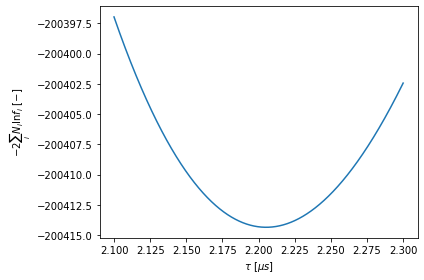

In [7]:
# Poissonverteilung


N = cut['Count'].sum()
t_1 = cut.at[24, 'start']   # Startzeit T1
t_k = cut.at[149, 'start']  # Anfang des letzten Bins
T = t_k + width           # Endzeit T


# Erwartungswerte f, gibt list mit f_i für i=[24...150] aus
def f(tau):
    N_0 = N / (np.exp(-1*t_1/tau) - np.exp(-1*T/tau))
    return [ N_0 * width * np.exp(-1*(cut.at[i+24, 'start'] + 0.5*width)/tau) / tau for i in range(126) ]

# Tau array für plot
tau_plot_poisson = np.linspace(2.1, 2.3, 10000)
# Berechnung der Max-Log-Likelihood Funktion
mllp = np.asarray([ 2*(-cut['Count'] * np.log(f(tau*1e-6))).sum() for tau in tau_plot_poisson ])

# Plotten der MLL Funktion
plt.plot(tau_plot_poisson, mllp)
plt.xlabel('$ τ \ [\mu s]$')
plt.ylabel('$-2\sum_i N_i \ln f_i \ [-]$')
plt.tight_layout()
plt.savefig('images/mllp.png', dpi=300)

tau_poisson = tau_plot_poisson[mllp.argmin()]   # Tau auswählen

# Finden der Breite eine Einheit über dem Minimum zur Messunsicherheitenabschätzung
i = 0
while mllp[mllp.argmin()]+1 > mllp[mllp.argmin()+i]:
    i -= 1

tau_links = tau_plot_poisson[mllp.argmin()+i]

i = 0
while mllp[mllp.argmin()]+1 > mllp[mllp.argmin()+i]:
    i += 1

tau_rechts = tau_plot_poisson[mllp.argmin()+i]

sigma_poisson = tau_rechts - tau_links



print('Aus der Poissonverteilung ergibt sich τ = {0} ± {1}'.format(tau_poisson, sigma_poisson))


Aus der Gaußverteilung ergibt sich τ = 2.188171817181718 ± 0.0544934493449345


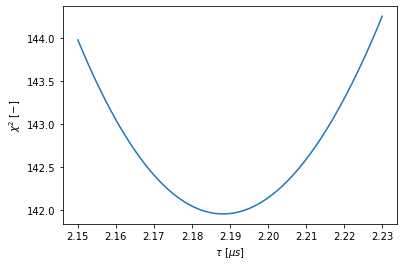

In [8]:
# Gaußverteilung
tau_plot = np.linspace(2.15, 2.23, 10000)

# Chi-Quadrat-Funktion
def chi_squared(tau):
    return ((cut['Count']-f(tau*1e-6))**2/cut['Count']).sum()

# Berechnung des Funktionswerts
chi_squared_plot = np.asarray([chi_squared(tau) for tau in tau_plot])

# Plotten Max-Log-Likelihood-Funktion
plt.plot(tau_plot, chi_squared_plot)
plt.xlabel('$ τ \ [\mu s]$')
plt.ylabel('$\chi^2 \ [-]$')
plt.savefig('images/mllg.png', dpi=300)
# Berechnung Tau
tau_gauss = tau_plot[chi_squared_plot.argmin()]

# Berechnung Standardabweichung Tau, analog zur Gaußverteilung
i = 0
while chi_squared_plot[chi_squared_plot.argmin()]+1 > chi_squared_plot[chi_squared_plot.argmin()+i]:
    i -= 1

tau_links = tau_plot[chi_squared_plot.argmin()+i]

i = 0
while chi_squared_plot[chi_squared_plot.argmin()]+1 > chi_squared_plot[chi_squared_plot.argmin()+i]:
    i += 1

tau_rechts = tau_plot[chi_squared_plot.argmin()+i]

sigma_gauss = tau_rechts - tau_links

print('Aus der Gaußverteilung ergibt sich τ = {0} ± {1}'.format(tau_gauss, sigma_gauss))